# (보관용) 기존 더미 데이터 생성 노트북

## 왜 보관하는가?
이 노트북에서 생성된 더미 데이터는 모델 실험 파이프라인 동작 확인에는 유용했지만,
모델 성능 평가에는 부적합한 구조적 문제가 있었다.

---

## 발견된 문제점

### 1) 클래스가 선형적으로 완전히 분리됨
위험군/정상군이 점수·행동 변수에서 명확히 분리되도록 생성되어
Logistic Regression 같은 단순 모델도 Accuracy/Recall 1.0이 쉽게 발생했다.

### 2) 교차(모순) 케이스가 부족함
현실 데이터에서 흔한 아래 케이스가 반영되지 않았다.
- 점수는 낮지만 참여/과제는 높은 학생
- 점수는 높지만 결석이 많은 학생
- 수행평가만 높고 지필평가가 낮은 학생 등

### 3) 테스트셋이 너무 작고 불균형함
테스트 샘플 수가 작아 성능이 과대평가될 수 있다.

---

## 개선 방향
새로운 `00_generate_dummy_dataset.ipynb`에서는 아래를 반영한다.

- 위험군/정상군 분포가 겹치도록 노이즈 추가
- 교차 패턴(모순 케이스) 명시적으로 생성
- 라벨을 단순 점수 임계값만으로 결정하지 않도록 설계
- 클래스 비율(정상/위험군)을 현실적으로 조정


## 메모: 더미 난이도 조정 시도 결과

여러 차례 노이즈/교차케이스/미래요인(endterm_effort) 등을 추가했으나,
02_risk_prediction에서 Logistic Regression 성능이 1.0으로 고정되는 현상이 지속되었다.

가능 원인:
- 더미 생성이 여전히 latent ability 중심으로 feature/label이 강하게 결합됨
- 표본 수/테스트셋이 작아 과대평가 발생 가능
- 현재 라벨(at_risk)이 특정 feature 조합으로 쉽게 역산 가능한 구조일 수 있음

향후 재개 시:
- 샘플 수 N을 1000~3000으로 확대
- StratifiedKFold 기반 교차검증으로 성능 안정성 확인
- 라벨 생성에서 feature와 독립인 요인의 비중을 더 크게 반영


## Import + 시드 + 기본 설정

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path

np.random.seed(42)

N = 300  # 샘플 수

DATA_DIR = Path("../data/dummy")
DATA_DIR.mkdir(parents=True, exist_ok=True)

print("Samples:", N)


Samples: 300


## 기본 잠재 능력(latent ability) 생성

완전 균등이 아니라 beta 분포 → 현실적 성취 분포

In [28]:
# 학생 잠재 학습 능력 (0~1)
ability = np.random.beta(a=2.5, b=2.0, size=N)

df = pd.DataFrame({
    "ability": ability
})

df.head()


,ability
0,0.666235
1,0.571014
2,0.654127
3,0.385052
4,0.921731


## 학기 중간 Feature 생성

In [29]:
# 중간고사
df["midterm_score"] = (
    df["ability"] * 70 +
    np.random.normal(0, 10, N)
).clip(0, 100)

# 수행평가
df["performance_score"] = (
    df["ability"] * 75 +
    np.random.normal(0, 12, N)
).clip(0, 100)

# 과제 제출
df["assignment_count"] = (
    df["ability"] * 10 +
    np.random.normal(0, 2, N)
).clip(0, 10).round()

# 결석
df["absence_count"] = (
    (1 - df["ability"]) * 8 +
    np.random.normal(0, 2, N)
).clip(0, 10).round()

# 질문
df["question_count"] = (
    df["ability"] * 5 +
    np.random.normal(0, 1.5, N)
).clip(0, 10).round()

# 상벌점
df["behavior_score"] = (
    df["ability"] * 5 +
    np.random.normal(0, 1, N)
).clip(0, 10).round()

# 야자
df["night_study"] = (df["ability"] > 0.5).astype(int)

# 참여도
df["participation_level"] = pd.cut(
    df["ability"],
    bins=[0, 0.4, 0.7, 1.0],
    labels=["하", "중", "상"]
)


## 교차 케이스 추가

In [30]:
# low_score_high_effort
idx = np.random.choice(df.index, size=int(N*0.1), replace=False)
df.loc[idx, "midterm_score"] *= 0.6
df.loc[idx, "assignment_count"] *= 1.3

# high_score_high_absence
idx = np.random.choice(df.index, size=int(N*0.1), replace=False)
df.loc[idx, "absence_count"] *= 1.5


## 학기 말 기말 점수(미래값) 생성

In [31]:
# 학기 말 기말 점수(미래 outcome) — ability + (학기 중간 행동의 일부 영향) + 노이즈
endterm_effort = np.random.normal(0, 1, N)

df["final_score_endterm"] = (
    df["ability"] * 60                 # 능력 영향 ↓
    + endterm_effort * 15              # 후반 노력 영향 ↑
    + (df["assignment_count"]/10) * 5
    - (df["absence_count"]/10) * 6
    + np.random.normal(0, 15, N)       # 노이즈 ↑
).clip(0, 100)


## 학기 말 성취율(미래) 계산

In [32]:
# 학기 말 성취율(미래) — 최종 산정에 'final_score_endterm' 포함
# 가중치는 예시(필요시 조정 가능)
w_mid, w_final, w_perf = 0.35, 0.35, 0.30

df["achievement_rate_endterm"] = (
    w_mid  * df["midterm_score"]
    + w_final * df["final_score_endterm"]
    + w_perf  * df["performance_score"]
).clip(0, 100)


## at_risk를 “확률 기반”으로 생성

In [33]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 위험 확률: 성취율 낮음 + 결석 많음 + 참여 낮음 요인이 위험 확률을 올림
# (학기 중간 feature가 위험에 영향을 주지만, 100% 결정적이지 않게 설계)
participation_num = df["participation_level"].map({"하": 0, "중": 1, "상": 2}).astype(float)

z = (
    -0.10 * (df["achievement_rate_endterm"] - 50)   # 성취율이 50보다 낮을수록 위험↑
    + 0.30 * (df["absence_count"] - 3)              # 결석이 많을수록 위험↑
    - 0.20 * (df["assignment_count"] - 5)           # 과제가 많을수록 위험↓
    - 0.25 * (participation_num - 1)                # 참여도가 높을수록 위험↓
    + np.random.normal(0, 1.0, N)                   # 확률 노이즈(핵심)
)

p_risk = sigmoid(z)

df["at_risk"] = (np.random.rand(N) < p_risk).astype(int)


## 위험군 비율 및 간단 체크

In [34]:
print("at_risk rate:", round(df["at_risk"].mean(), 3))

# 위험군이 '대체로' 성취율이 낮고 결석이 높은지 확인(완벽 분리되면 안됨)
summary = df.groupby("at_risk")[["achievement_rate_endterm","absence_count","assignment_count","midterm_score","performance_score"]].mean()
display(summary)


at_risk rate: 0.6


,achievement_rate_endterm,absence_count,assignment_count,midterm_score,performance_score
at_risk,,,,,
0,51.187700,2.083333,7.235833,49.890356,53.661089
1,31.170902,4.941667,4.794444,31.127366,35.841218


## student_id 추가 + 저장용 컬럼 정리

In [35]:
# student_id 생성 (비식별)
df["student_id"] = [f"S{str(i).zfill(4)}" for i in range(1, N+1)]

# 저장용 기본 스키마 컬럼(학기 중간 feature 기준)
schema_cols = [
    "student_id",
    "midterm_score",
    "final_score",            # (midterm_like에서는 NaN으로 둘 예정)
    "performance_score",
    "assignment_count",
    "participation_level",
    "question_count",
    "night_study",
    "absence_count",
    "behavior_score",
    "at_risk",                # 미래 라벨을 포함해서 저장
]

# full-term 데이터(학기 말 가정): final_score=final_score_endterm
df_full = df.copy()
df_full["final_score"] = df_full["final_score_endterm"]

# midterm snapshot 데이터: final_score는 비어있음(미래 미관측)
df_mid = df.copy()
df_mid["final_score"] = np.nan

df_full_out = df_full[schema_cols].copy()
df_mid_out  = df_mid[schema_cols].copy()

df_full_out.head(), df_mid_out.head()


(  student_id  midterm_score  final_score  performance_score  assignment_count  \
 0      S0001      53.159702    31.942077          19.320596               6.0   
 1      S0002      24.207081    37.670460          54.037913               8.0   
 2      S0003      60.554272    61.234848          32.656957               9.0   
 3      S0004      40.754560    21.575097          26.181722               9.0   
 4      S0005      58.265514    64.316524          55.088438              10.0   
 
   participation_level  question_count  night_study  absence_count  \
 0                   중             2.0            1            4.5   
 1                   중             1.0            1            3.0   
 2                   중             3.0            1            5.0   
 3                   하             3.0            0            5.0   
 4                   상             4.0            1            0.0   
 
    behavior_score  at_risk  
 0             2.0        0  
 1             2.0      

## 저장 (기존 파일명으로 덮어쓰기)

In [36]:
# 저장 경로 (기존 파일명 유지)
full_path = DATA_DIR / "dummy_full.csv"
mid_path  = DATA_DIR / "dummy_midterm_like.csv"

df_full_out.to_csv(full_path, index=False, encoding="utf-8-sig")
df_mid_out.to_csv(mid_path, index=False, encoding="utf-8-sig")

print("saved:", full_path)
print("saved:", mid_path)
print("full shape:", df_full_out.shape, "mid shape:", df_mid_out.shape)


saved: ..\data\dummy\dummy_full.csv
saved: ..\data\dummy\dummy_midterm_like.csv
full shape: (300, 11) mid shape: (300, 11)


## labeled 버전도 저장

In [37]:
full_labeled_path = DATA_DIR / "dummy_full_labeled.csv"
mid_labeled_path  = DATA_DIR / "dummy_midterm_like_labeled.csv"

df_full_out.to_csv(full_labeled_path, index=False, encoding="utf-8-sig")
df_mid_out.to_csv(mid_labeled_path, index=False, encoding="utf-8-sig")

print("saved:", full_labeled_path)
print("saved:", mid_labeled_path)


saved: ..\data\dummy\dummy_full_labeled.csv
saved: ..\data\dummy\dummy_midterm_like_labeled.csv


## 난이도 검증

midterm-like at_risk rate: 0.6


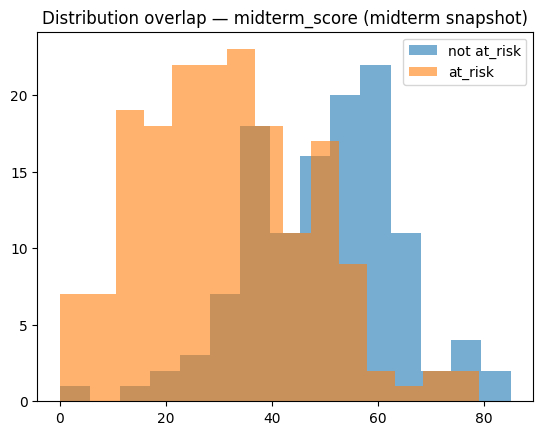

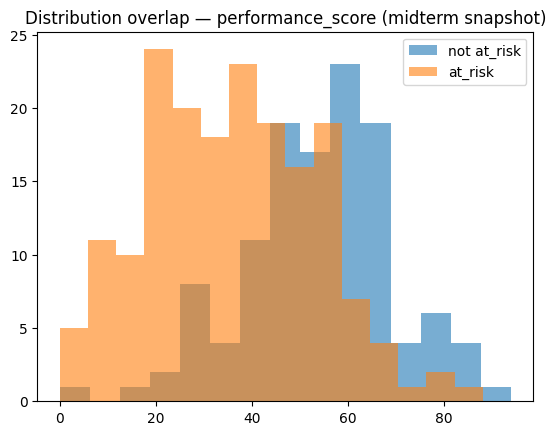

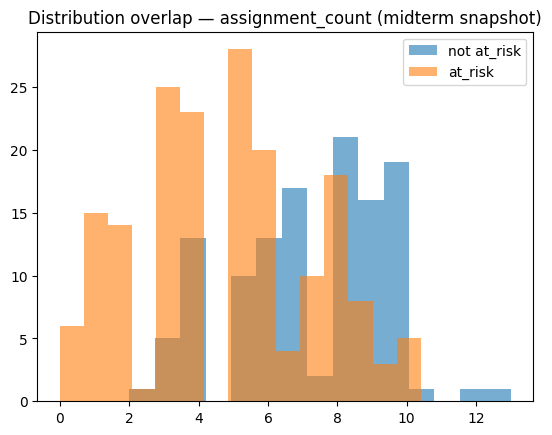

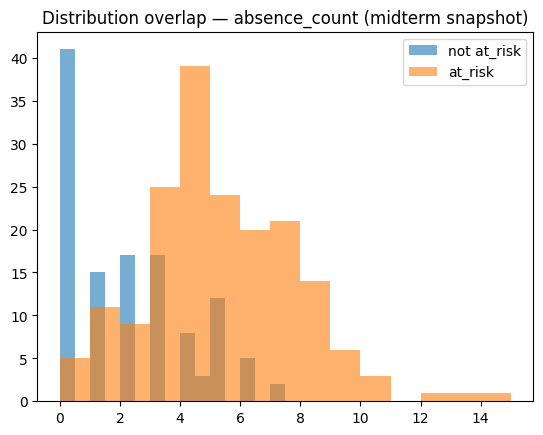

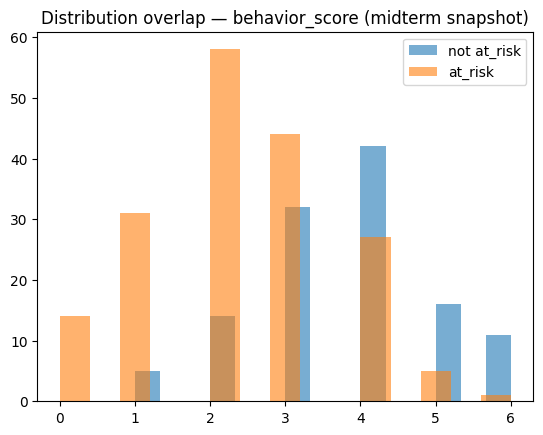

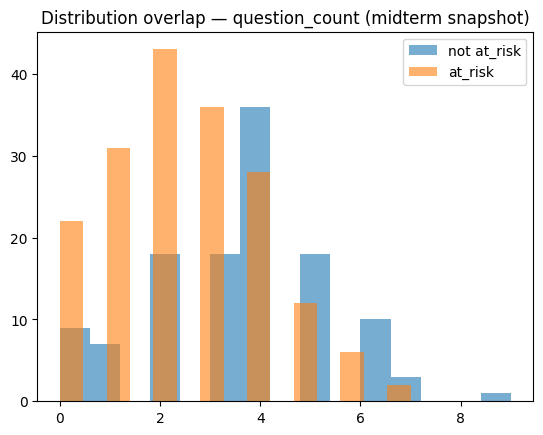

In [38]:
import matplotlib.pyplot as plt

check_cols = ["midterm_score", "performance_score", "assignment_count", "absence_count", "behavior_score", "question_count"]

# midterm snapshot 기준으로 확인
tmp = df_mid_out.copy()

print("midterm-like at_risk rate:", round(tmp["at_risk"].mean(), 3))

for col in check_cols:
    plt.figure()
    risk0 = tmp.loc[tmp["at_risk"] == 0, col].dropna()
    risk1 = tmp.loc[tmp["at_risk"] == 1, col].dropna()

    plt.hist(risk0, bins=15, alpha=0.6, label="not at_risk")
    plt.hist(risk1, bins=15, alpha=0.6, label="at_risk")
    plt.title(f"Distribution overlap — {col} (midterm snapshot)")
    plt.legend()
    plt.show()


## 데이터 사전(data_dictionary.csv) 업데이트

In [39]:
data_dict = pd.DataFrame([
    ["student_id", "비식별 학생 ID"],
    ["midterm_score", "중간고사 성적"],
    ["final_score", "기말고사 성적 (학기 중간 스냅샷에서는 NaN 가능)"],
    ["performance_score", "수행평가 성적"],
    ["assignment_count", "과제 제출 횟수"],
    ["participation_level", "수업 참여도 (상/중/하)"],
    ["question_count", "수업 중 질문 횟수"],
    ["night_study", "야간자율학습 참여 여부 (0/1)"],
    ["absence_count", "결석 횟수"],
    ["behavior_score", "상벌점"],
    ["at_risk", "최성보 위험군 라벨(학기 말 기준, 조기 예측 대상)"],
], columns=["column", "description"])

dict_path = DATA_DIR / "data_dictionary.csv"
data_dict.to_csv(dict_path, index=False, encoding="utf-8-sig")
print("saved:", dict_path)


saved: ..\data\dummy\data_dictionary.csv
